# Thesis: An Analysis of Political Sentiment and the Role of Fake Accounts among Twitter Election Messages 

## Import Libraries

In [ ]:
#Install packages if not present already
#pip install twitterscraper
#pip install botometer

In [1]:
from twitterscraper import query_tweets
import datetime as dt
import pandas as pd
import numpy as np
import nltk
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import re
from string import punctuation

import glob
import os
from pathlib import Path

from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers.core import Activation, Dense
from keras.layers import Dropout, GlobalMaxPooling1D, Conv1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

INFO: {'User-Agent': 'Mozilla/5.0 (compatible, MSIE 11, Windows NT 6.3; Trident/7.0; rv:11.0) like Gecko', 'X-Requested-With': 'XMLHttpRequest'}
Using TensorFlow backend.


## User Defined functions
### All functions written for this script

In [2]:
# function for retrive tweets using Twitterscraper
# paramters passed: list of keywords, begin and end date, language
def getTweets(keywords,startDate,endDate,lang):
    #Create new dataframe for storing tweets
    finalDF = pd.DataFrame()
    #Loop through keywords to get tweets as each query term
    for term in keywords:
        tweets = query_tweets(term, begindate = startDate, enddate = endDate, lang=lang)
        df = pd.DataFrame(t.__dict__ for t in tweets)
        finalDF = electionTweets2019.append(df)
    
    return finalDF

# function to preprocess the tweets
# 
def pre_process(text):
    sentence = re.sub(r'<[^>]+>', ' ', text)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = re.sub(r'#\S+|@\S+', ' ', sentence)
    sentence = sentence.lower()
    return sentence

# function to repeat words in full caps 
def repeatCapitalWords(text):
    t = " ".join(re.findall(r"\b[A-Z\s]+\b", text))
    return text + t

# function to categorize tweets based on party keywords
def categorize(text):
    text = text.lower()
    category = "BJP"
    # declaring keywords for each party
    BJP = ["bjp4india","bharatiya janata party","bjp","nda ","narendra","narendramodi","namo","modi"]
    INC = ["incindia","cong ","congress","inc ","upa ","rahul gandhi","rahulgandhi","raga","gandhi"]
    
    if any(x in text for x in BJP):
        if any(x in text for x in INC):
            category = "Both"
    elif any(x in text for x in INC):
        category = "Congress"
    else:
        category = "None"
            
    return category

# fuction to use botomter to get bot score for each account
def getBotScore(id):
    try:
        result = bom.check_account(id)['scores']['universal']
    except:
        result = np.nan
    
    return result

# Function to assign account type based on bot score
# Simple Bot: Greater than/equal to 0.8
# Human-like Bots: Between 0.4 and 0.8
# Human: Less than 0.4

def checkBotStatus(score):
    status = 'Human'
    
    if score >= 0.8:
        status = 'Simple Bot'
    elif 0.4 < score < 0.8:
        status = 'Human-like Bot'
    elif math.isnan(score):
        status = 'Suspended'
        
    return status

## Data

### Set Keywords

In [ ]:
# Here we set the keywords for the three different categories of hashtags: 
#Generic election, candiate specific and party specific

# Generic Hashtgas used 
electionKeywords = ['#2019LokSabhaElections',  '#2019LokSabhapolls', '#2019OpinionPoll', 
                    '#BattleOf2019', '#ButtonDabaoDeshBanao', 
                    '#CountingDay',
                    '#Election2019', '#ElectionCommission', '#ElectionCommissioner', '#ElectionDirtyCash', '#ElectionResults2019', '#ElectionWar2019', '#Elections2019', '#ElectionAlert','#ElectionDay', '#ElectionSuperT20', '#ElectionUpdate', '#ElectionsOnMyPlate', '#ExitPoll', '#ExitPoll2019', '#ExitPoll2019Results', '#ExitPollPhobia', '#ExitPolls',
                    '#GeneralElections', '#GeneralElections2019', 
                    '#India2019', '#IndiaElects', '#IndiaVotes', '#IndiaElections', '#IndianElections2019', '#Indiavotes', '#LokSabha2019','#IndiaElections2019' , '#IndiaDecides2019'
                    '#LokSabhaChunav2019','#LokSabhaElection2019', '#LokSabhaElectionResults', '#LokSabhaElections', '#LokSabhaElections2019', '#LokSabhaPolls2019', '#Loksabha2019', 
                    '#LoksabhaElections2019', '#LoksabhaElection2019', 
                    '#Mandate2019', '#Mission2019', '#MyIndiaMyVote', 
                    '#PollOfPolls', '#PollofPolls', 
                    '#ResultDay', '#Verdict2019',
                    '#Vote4India', '#VoteBecauseYouCan', '#VoteForChange', '#VoteForIndia', '#VoteForNewIndia', '#VoteIndia', '#VoteforIndia', '#VoteWiselyIndia']

# Candidate specific hashtagsused 
candidateKeywords = ['#AaplaRahulGandhi','#AmchoRahulGandhi','#ArunachalWelcomesRahulGandhi',
                     '#BiharRejectsModi','#BiharWithModi',
                     '#ChowkidarNarendraModi',
                     '#EkBarFirModiSarkar',
                     '#FIRagainstCorruptModi',	
                     '#GoBackAntiNationalModi','#GoBackRahul','#GoBackModi','#GoBackPappu','#GoBackSadistModi','#GoodByeModi','#GujaratSaysNaMoAgain',
                     '#MODIfiedJobs','#MPWithNaMo','#MaharashtraMODIfied','#MissionModi2019',
                     '#Modi','#Modi2019Wave','#ModiAgain2019','#ModiChantSpooksCong','#ModiCorruptionYaadRakhna',
                     '#ModiInAmethi','#ModiInGujarat','#ModiOnceMore',
                     '#ModiTransformsBharat','#ModiVsPakistan','#ModiVsPappu','#ModiVsWho','#ModiWhereIsOurMoney','#MyFirstVoteForModi',
                     '#NammaRahulGandhi','#NaMoAgain','#NaMoAgainAngersCong',
                     '#PhirEkBaarModiSarkar',
                     '#RaGaFromKarnataka','#RahulDemocracyDialogue','#RahulFromTamilNadu','#RahulGandhi','#RahulGandhiLieChallenge',
                     '#RahulGandhiWithFishermen','#RahulLovesTerrorist',
                     '#RahulPoliticisesPulwama','#RahulTakingIndiaForward',
                     '#TNNaMoWarriors','#TNWelcomesModi','#TeamModi','#TripuraWelcomesRahulGandhi',
                     '#VanakkamRahulGandhi','#VaravayiRahulGandhiYugam',
                     '#WelcomeRahulGandhi','#WhyModiAgain']

# Party specific hashtags used 
partyKeywords = ['#AntiNationalCongress', '#BJP2019Manifesto', '#BJP4BIHAR', '#BJPBetrayedDelhi', '#BJPCandidateList', '#BJPFirstList', '#BJPGameOfThieves', '#BJPInsultsMartyr', 
                 '#BJPJootaFight', '#BJPJumlaManifesto', '#BJPKiList2019', '#BJPLoanJumla', '#BJPLovesTerrorists', '#BJPMLA', '#BJPMP', '#BJPManifesto', '#BJPPollManifesto', '#BJPFoundationDay', 
                 '#BJPSankalpPatr2019', '#BJPSankalpPatra', '#BJPSthapnaDiwas', '#BJPTerrorism', '#BJPVIjaySankalpBikeRally', '#BJPVijaySankalp', '#BJPVijaySankalpBikeRally', '#BJPWebsiteHacked', 
                 '#BJPWinning', '#BJPwithKasab', '#BJPlist', '#BJPvsBJP', '#BiharNDA', '#BjpKiList2019', '#BjpWebsitehacked', '#BjpWithKasab', '#CONgressEkBailKatha', '#Cong15LakhStunt', '#CongAbsolvesPak', 
                 '#CongAdmitsJhoot', '#CongAgainstSedition', '#CongAntiForcesCampaign', '#CongArmsDealerWeb', '#CongBasicIncomeVow', '#CongBharatMataClaim', '#CongCashRaids', '#CongCasteCard', 
                 '#CongFakeCampaign', '#CongForPakistan', '#CongHawalaCashNote', '#CongInsultsMartyrs', '#CongKaCashForVote', '#CongManifesto', '#CongMasoodJhoot', '#CongMuslimVote', '#CongPollPledge', 
                 '#CongRamBhaktLie', '#CongSuperEmergency', '#CongTerrorSamjhauta', '#CongViolenceAlliance', '#CongVsForces', '#CongVsNationalInterest', '#CongizOnBackfoot', '#Congress', 
                 '#CongressAgainstDalits', '#CongressChorHai', '#CongressCollapse', '#CongressFakesItOnFB', '#CongressHaiNa', '#CongressHatesMiddleClass', '#CongressHelpingBJP', '#CongressInVidarbha', 
                 '#CongressInsultsIndia', '#CongressKaKalank', '#CongressKiFakeDiaries', '#CongressKiTerrorPolitics', '#CongressMainfesto', '#CongressManifesto', '#CongressMission25', '#CongressMuktBharat', 
                 '#CongressNaalPunjabKhushhaal', '#CongressWithPakistan', '#CongressWillDeliver', '#CongressWorkingCommittee', '#DelhiMaangeCongress', '#EtharaCongress', '#FakeItLikeCongress', 
                 '#FirstPhaseBJPFails', '#GoBackFascistBJP', '#INCForWomen', '#MahilaVirodhiBJP',  '#MasoodJiKeSaathCong', '#MyVoteForCongress', '#SayNoToBJP', '#ShameOnCongress',  '#SilentWomenOfBJP', 
                 '#TelanganaProgressWithCongress', '#UPAPoliticalSting', '#VampireCongress', '#Vote4BJP', '#Vote4Bjp', '#VoteForBJP',  '#VultureCongress', '#WomenBewareofBJP', '#BJP4India', '#BJPForIndia', 
                 '#BJPScaredOfKejriwal', '#BJPSupportsTerrorists', '#BJPWinningAmethi', '#BJPgoonBidhuri', '#BJPseDemocracyBachao', '#BengalWithBJP', '#Cong1984Shocker', '#Cong287CrCashFile', 
                 '#Cong6StrikeFactCheck', '#CongAbusesRashtrapati', '#CongAttacksSavarkar', '#CongBachaoRahulHatao', '#CongForImran', '#CongInsultsAamAadmi', '#CongInsultsPoor', '#CongKaSelfGoalHua', 
                 '#CongMediaBoycott', '#CongNeechAttackPart2', '#CongPraisesJinnah', '#CongSaffronSOS', '#CongShatruKeSaath', '#CongVsVadras', '#Conginsultspoor', '#CongressNeverAgain', '#CongressParty', 
                 '#DilliKeDilMeinCongress', '#HogiCongressKiJeet', '#IYCwithRahul', '#IndiaWithCongress', '#MeraVoteCongressKo', '#MeriAwazMeriCongress', '#NDAParliamentaryMeeting', '#TNRejectsBJP', 
                 '#VoteCutterCong', '#VoteKatwaCongress', '#congAttacksSavarkar']


### Run for each set of keywords and get tweets
### Save the tweets in a file for each keyword category

In [ ]:
# Declare start and end dates
start_date = dt.date(2019, 1, 1) # first day of the year
end_date = dt.date(2019, 5, 23) # day of election results

#Create dataframe for generic election keywords
electionTweets2019 = getTweets(keywords = electionKeywords,
                               startDate = start_date,
                               endDate = end_date,
                               lang = 'en')
electionTweets2019.to_csv("electionTweets2019.csv")

#Create dataframe for generic election keywords
candidateTweets2019 = getTweets(keywords = candidateKeywords,
                               startDate = start_date,
                               endDate = end_date,
                               lang = 'en')
candidateTweets2019.to_csv("candidateTweets2019.csv")

#Create dataframe for generic election keywords
partyTweets2019 = getTweets(keywords = partyKeywords,
                               startDate = start_date,
                               endDate = end_date,
                               lang = 'en')
partyTweets2019.to_csv("partyTweets2019.csv")

### Load files and merge to get final dataset

In [3]:
# Read three files with all the tweets

electionTweets2019 = pd.read_csv("./Data/electionTweets2019.csv")
candidateTweets2019 = pd.read_csv("./Data/candidateTweets2019.csv")
partyTweets2019 = pd.read_csv("./Data/partyTweets2019.csv")

# merge the three dataframes
tweets2019 =  pd.concat([electionTweets2019, candidateTweets2019, partyTweets2019], ignore_index=True)
#size of dataset
tweets2019.shape

(161324, 22)

### Pre-processing of tweets

In [4]:
# get actual tweets and not replies 
tweets2019 = tweets2019[tweets2019['is_reply_to' ] == False]

# dropping duplicate values 
tweets2019 = tweets2019.drop_duplicates(subset = 'tweet_id')

# drop tweets from media agencies, news channels, newspapers
tweets2019 = tweets2019[tweets2019['username']
                        .str.contains("news|tv|times|media|toi|council|statesman|mandate|press|now|firstpost|Live|deccan|express|outlook|the ", case= False) == False]

# extract selected columns 
tweets2019 = tweets2019.filter(['tweet_id','timestamp','text', 'user_id','username', 'screen_name'], axis=1).sort_values(by=['tweet_id']).reset_index()

#rename columns
tweets2019.rename(columns={'tweet_id':'TweetID',
                           'timestamp':'TimeStamp',
                           'text' : 'Tweet', 
                           'user_id' : 'UserID',
                           'username' : 'UserName', 
                           'screen_name' : 'ScreenName'},
                  inplace=True)

# drop index column
tweets2019 = tweets2019.drop(['index'],axis = 1)

# add new column categorise tweets by parties
tweets2019['Party'] = tweets2019['Tweet'].apply(categorize)

# drop all entries with no party category
tweets2019 = tweets2019[tweets2019['Party']!='None']

# add capitalized words again to text
tweets2019['Tweet'] = tweets2019['Tweet'].apply(repeatCapitalWords)

# Remove all hyperlinks, whitespaces and twitterhandles
tweets2019 = tweets2019.assign(Tweet = lambda x: x["Tweet"].str.replace(r"http\S+|#\S+|@\S+", "", regex=True)) 
tweets2019 = tweets2019.assign(Tweet = lambda x: x["Tweet"].str.replace(r"pic.twitter\S+", "", regex=True)) 

# apply pre-process steps
tweets2019['Tweet'] = tweets2019['Tweet'].apply(pre_process)

# Save dataset to file
tweets2019.to_csv("./Data/Tweets2019.csv")

# size of dataset after pre-processing
tweets2019.shape

(85193, 7)

### Load final dataset from file

In [5]:
#tweets2019 = pd.read_csv("./Data/Tweets2019.csv")

# tweet count for each party category
tweets2019.groupby(['Party']).size().reset_index(name='Count')

,Party,Count
0,BJP,32731
1,Both,20832
2,Congress,31630


## Part 1: Checking for Bot

In [ ]:
# load package
import botometer

# set rapid api key
rapidapi_key = "761c3f590emsha5c171f2911c27bp1f4826jsnbbac887cd7d5" # now it's called rapidapi key

# set twitter developer credentials
twitter_app_auth = {
    'consumer_key': 'bfSuAdueneFZpRvA9Pwrx3VtG',
    'consumer_secret': '8sL2mXYkPyz8YjqP0WO7bHPaHsjMc7EuPQT41ekRjbSxhdVwze',
    'access_token': '855084907365715968-a9rslInMObUk0R91CWVStf7SPiIRble',
    'access_token_secret': 'HpPuzBC516Hri88qHtc2NU973iVDO4nofqtuooPTtZtnT',
  }

# create instance of botometer class to get bot score
bom = botometer.Botometer(wait_on_ratelimit=True,
                          rapidapi_key=rapidapi_key,
                          **twitter_app_auth)

### Get all unique user ids from Twitter Election dataset

In [6]:
userIdDF = tweets2019[['UserID', 'ScreenName','Party']].drop_duplicates(subset = 'UserID')
userIdDF.groupby(['Party']).size().reset_index(name='Count').sort_values(by='Count',ascending=False)

,Party,Count
0,BJP,14846
2,Congress,12509
1,Both,7756


### Get bot score for each unique user, based on the party category
### Save the details in a file

In [ ]:
# Get Unique ids for BJP and get Bot score for each
userId_BJP = userIdDF[userIdDF['Party']=='BJP']
userId_BJP['BotScore'] = userId_BJP['UserID'].apply(getBotScore)
userId_BJP.to_csv("./Data/userId_BJP.csv")

# Get Unique ids for Congress and get Bot score for each
userId_Congress = userIdDF[userIdDF['Party']=='Congress']
userId_Congress['BotScore'] = userId_Congress['UserID'].apply(getBotScore)
userId_Congress.to_csv("./Data/userId_Congress.csv")

# Get Unique ids that tweeted for both BJP and Cpngress and get Bot score for each
userId_Both = userIdDF[userIdDF['Party']=='Both']
userId_Both['BotScore'] = userId_Both['UserID'].apply(getBotScore)
userId_Both.to_csv("./Data/userId_Both.csv")

### Once all the scores were retreived, we merge the datasets together to get a combined dataset for all the unique user ids

In [7]:
# Since we already have data saved in the files, we load the files rather running the script each time 
userId_BJP = pd.read_csv("./Data/userId_BJP.csv")
userId_Congress = pd.read_csv("./Data/userId_Congress.csv")
userId_Both = pd.read_csv("./Data/userId_Both.csv")

# Merge all three datasets
userIDScoreCombined =  pd.concat([userId_BJP, userId_Congress, userId_Both], ignore_index=True)

In [8]:
# Code to make sure we only extract all the unique user ids present in Twitter Election dataset
userIDScoreCombined = pd.merge(userIdDF,userIDScoreCombined,on=['UserID', 'ScreenName', 'Party'],how='left')
userIDScoreCombined = userIDScoreCombined = userIDScoreCombined[['UserID','ScreenName','Party','BotScore']]

# Assign account type based on the Bot score for each user
userIDScoreCombined['Status'] = userIDScoreCombined['BotScore'].apply(checkBotStatus)

# Size of dataset: no of unique users
userIDScoreCombined.shape

(35111, 5)

In [9]:
# See count for each account type
userIDCount = userIDScoreCombined.groupby(['Status']).size().reset_index(name='Count')
userIDCount

,Status,Count
0,Human,28973
1,Human-like Bot,4334
2,Simple Bot,1141
3,Suspended,663


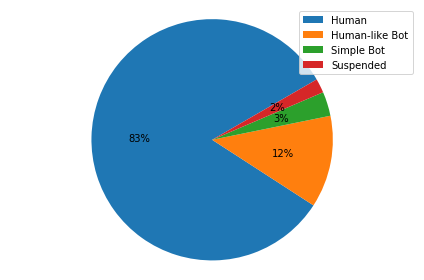

In [10]:
# Create a pie chart
plt.pie(
    # using tweets
    userIDCount['Count'],
    # with no shadows
    shadow=False,
    # with the start angle at 30%
    startangle=30,
    # with the percent listed as a fraction
    autopct='%1.0f%%'
    )

# View the plot drop above
plt.axis('equal')
plt.legend(userIDCount['Status'], loc="best")
# View the plot
plt.tight_layout()
plt.savefig('./Plots/pie.png')
plt.show()

In [11]:
# check distribution of each account type for all party categories
botCountDF = userIDScoreCombined.groupby(['Status','Party']).size().reset_index(name='Count').pivot(index='Party',columns='Status',values='Count')
botCountDF['Total'] = botCountDF.sum(axis=1)
botCountDF = botCountDF.sort_values(by='Total',ascending=False)
botCountDF

Status,Human,Human-like Bot,Simple Bot,Suspended,Total
Party,,,,,
BJP,12245,1915,589,97,14846
Congress,10180,1531,301,497,12509
Both,6548,888,251,69,7756


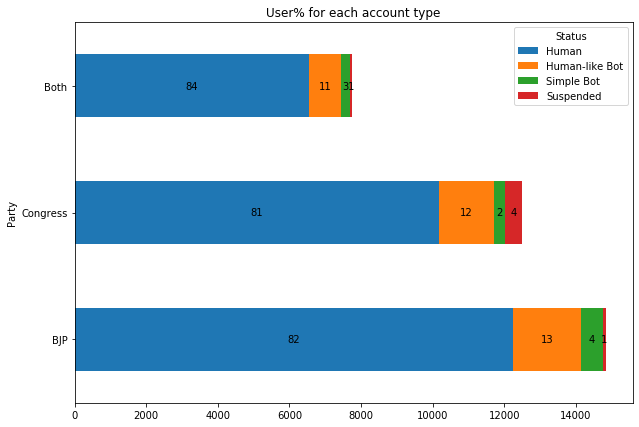

In [12]:
# Plot for distribution of each account type for all party categories
df_total = botCountDF['Total']
df = botCountDF.iloc[:, 0:4]
df.plot(kind='barh',stacked = True,title = 'User% for each account type', mark_right = False,  figsize=(10,7))

df_rel = df[df.columns[:]].div(df_total, 0)*100

for n in df_rel:
    for i, (cs, ab, pc, tot) in enumerate(zip(df.iloc[:, 0:].cumsum(1)[n], df[n], df_rel[n], df_total)):
        #plt.text(tot, i, str(tot), va='center')
        plt.text(cs - ab/2, i, str(int(np.round(pc, 0))) , va='center', ha='center')

plt.savefig('./Plots/botCount.png')

### Assign account type based on user id for each user in Twitter Election dataset

In [13]:
tweets2019 = pd.merge(tweets2019,userIDScoreCombined[['UserID','Status']], on='UserID',how='left')

In [14]:
# check distribution of tweets for all party categories based on account type
tweetBotCountDF = tweets2019.groupby(['Status','Party']).size().reset_index(name='Count').pivot(index='Party',columns='Status',values='Count')
tweetBotCountDF['Total'] = tweetBotCountDF.sum(axis=1)
tweetBotCountDF = tweetBotCountDF.sort_values(by='Total',ascending=False)
tweetBotCountDF

Status,Human,Human-like Bot,Simple Bot,Suspended,Total
Party,,,,,
BJP,27801,3675,867,388,32731
Congress,26566,3563,515,986,31630
Both,17466,2270,757,339,20832


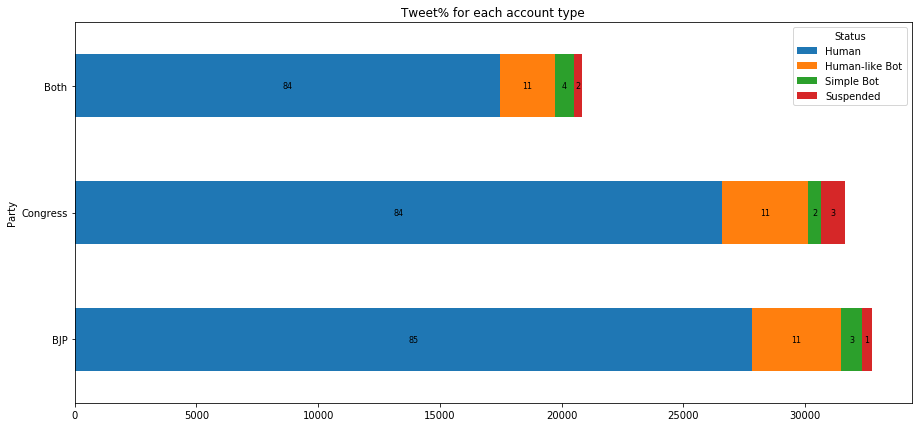

In [15]:
# plot distribution of tweets for all party categories based on account type
df_total = tweetBotCountDF['Total']
df = tweetBotCountDF.iloc[:, 0:4]
df.plot(kind='barh',stacked = True, title = 'Tweet% for each account type', mark_right = False,  figsize=(15,7))

df_rel = df[df.columns[:]].div(df_total, 0)*100

for n in df_rel:
    for i, (cs, ab, pc, tot) in enumerate(zip(df.iloc[:, 0:].cumsum(1)[n], df[n], df_rel[n], df_total)):
        plt.text(cs - ab/2, i, str(int(np.round(pc, 0))) , va='center', ha='center', size = 8)

plt.savefig('./Plots/tweetBotCount.png')

## Part 2: Sentiment Analysis

## Training Data: Sentiment140

In [16]:
# Column names for relevant columns
colNames = ['Sentiment', 'TweetID', 'Date', 'Query', 'Username','Text']
# Load Sentiment140 dataset from file
trainingDataSet = pd.read_csv("./Data/Sentiment140.csv", names = colNames, encoding= 'ISO-8859-1',header=None)

# Take sample of Sentiment140 dataset for training data
trainingDataSet = trainingDataSet.sample(frac = 0.125, random_state = 100)

#Change all positive sentiment values from 4 to 1
trainingDataSet.loc[trainingDataSet['Sentiment'] == 4, 'Sentiment'] = 1

#  check for capitalized words and add to text
trainingDataSet['Text'] = trainingDataSet['Text'].apply(repeatCapitalWords)

# Remove all hyperlinks, whitespaces and twitterhandles, if any
trainingDataSet = trainingDataSet.assign(Text = lambda x: x["Text"].str.replace(r"http\S+|#\S+|@\S+", "", regex=True)) 
trainingDataSet = trainingDataSet.assign(Text = lambda x: x["Text"].str.replace(r"pic.twitter\S+", "", regex=True)) 

# size of dataset
trainingDataSet.shape

(200000, 6)

In [17]:
# check if equal distribution of positive and negative tweets
trainingDataSet.groupby(['Sentiment']).count()

,TweetID,Date,Query,Username,Text
Sentiment,,,,,
0,100202,100202,100202,100202,100202
1,99798,99798,99798,99798,99798


## Glove Word Embedding

In [18]:
# Read word embeddings
#glove_file = open('./glove.6B.100d.txt', encoding="utf8")
glove_file = open('./Data/glove.twitter.27B.100d.txt', encoding="utf8")
dictionary = {}

for line in glove_file:
    values = line.split()
    word = values[0]
    try:
        vector = np.asarray(values[1:], dtype='float32')
    except:
        print(values[1:])
    
    dictionary[word] = vector

## Train-Test Split

In [19]:
# split Sentiment140 dataset into training and test set for the model
trainData, testData = train_test_split(trainingDataSet, test_size=0.2, random_state=100)
print(trainData.groupby(['Sentiment']).count(), testData.groupby(['Sentiment']).count())

           TweetID   Date  Query  Username   Text
Sentiment                                        
0            80277  80277  80277     80277  80277
1            79723  79723  79723     79723  79723            TweetID   Date  Query  Username   Text
Sentiment                                        
0            19925  19925  19925     19925  19925
1            20075  20075  20075     20075  20075


## Pre-processing for model

In [20]:
# Create X and Y numpy arrays; preprocessing required for keral model 
# X: Text of the tweet; Y: Sentiment of the tweet (0,1)

# Create X and Y numpy arrays for training set
train_text_array = trainData["Text"].to_numpy()
X_train = [pre_process(text) for text in train_text_array]
y_train = trainData["Sentiment"].to_numpy()

# Create X and Y numpy arrays for test set
test_text_array = testData["Text"].to_numpy()
X_test = [pre_process(text) for text in test_text_array]
y_test = testData["Sentiment"].to_numpy()

# Create numpy arrays for training set
electionTweet_array = tweets2019["Tweet"].to_numpy()
electionTweet = [pre_process(text) for text in electionTweet_array]

# Create a dictionary by converting each vocabulary word into an index value
tknzr = Tokenizer(num_words = 5000)
tknzr.fit_on_texts(X_train)

# Transform the tweets into a set of numbers using tokenizer
X_train = tknzr.texts_to_sequences(X_train)
X_test = tknzr.texts_to_sequences(X_test)
electionTweet = tknzr.texts_to_sequences(electionTweet)

# +1 because Keras in keras the index 0 is reserved
vocabulary_size = len(tknzr.word_index) + 1

# Max length of the tweet. Each tweet that is longer is truncated; in this case not possible as max permissible length of tweet is 140 characters
max_length = 140

# Tweets that are shorter are padded with 0s
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
electionTweet = pad_sequences(electionTweet, padding='post', maxlen=max_length)

## Create Word Embedding

In [21]:
# Create embedding matrix where each row is the index representing a word and columns represent vectorspace dimensions
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tknzr.word_index.items():
    embedding = dictionary.get(word)
    if embedding is not None:
        embedding_matrix[index] = embedding

## Convolutional Neural Network Model

In [22]:
# set seed 
from numpy.random import seed
seed(10)

# Callback function to stop the training early if the accuracy on the validation score drops for 2 consecutive epochs.
es =  EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=2,
                   verbose=1, mode='auto')

# Create a sequential model
model = Sequential()

# embedding layer
embedding_layer = Embedding(vocabulary_size, 100, weights=[embedding_matrix], input_length=max_length , trainable=False)
model.add(embedding_layer)

# dropout layer with 20% probability
model.add(Dropout(0.2))

# convolutional layers
model.add(Conv1D(200, 3, padding = "valid", activation='relu')) #kernel size 3, for trigrams
model.add(Conv1D(200, 2, padding = "valid", activation='relu')) #kernel size 2, for bigrams

# max pooling layer
model.add(GlobalMaxPooling1D())

# fully connected layer
model.add(Dense(100))
# dropout layer with 20% probability
model.add(Dropout(0.2))

#output layer
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# display model summary
print(model.summary())

# model training 
history = model.fit(X_train, y_train, batch_size=64, epochs=7, verbose=1, validation_split=0.2, callbacks=[es])

# get model metrics
score = model.evaluate(X_test, y_test, verbose=1)

# display model metrics
print("Score:", round(score[0],2)*100,"%")
print("Accuracy:", round(score[1],2)*100,"%")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 100)          6731700   
_________________________________________________________________
dropout_1 (Dropout)          (None, 140, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 138, 200)          60200     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 137, 200)          80200     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)              

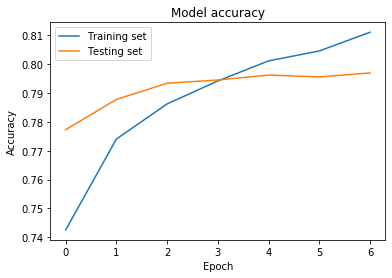

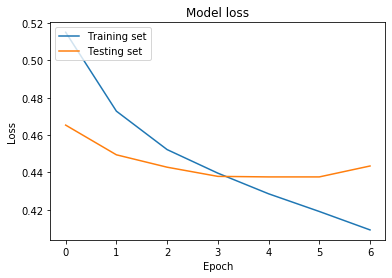

In [23]:
#Code gotten from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set','Testing set'], loc='upper left')
plt.savefig("./Plots/accuracy.png")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set','Testing set'], loc='upper left')
plt.savefig("./Plots/loss.png")
plt.show()

### Predict sentiment for Twitter Election dataset

In [24]:
# get predicted sentiment labels (0,1) 
# add values to new columns in dataset 
sentiment_pred = model.predict_classes(electionTweet)
sentiment_pred = np.reshape(sentiment_pred,(sentiment_pred.shape[0],))
tweets2019["Predicted Sentiment"] =  sentiment_pred

# Set sentiment as 'Positive' if label is 1, else set as 'Negative'
tweets2019["Predicted Sentiment"] = tweets2019["Predicted Sentiment"].apply(lambda x: 'Positive' if x==1 else 'Negative')

In [25]:
# check distribution/percentage of predicted sentiment 
tweetSentiment = tweets2019.groupby(['Predicted Sentiment']).size().reset_index(name='Count')
tweetSentiment['Percentage'] = round((tweetSentiment['Count'] / tweetSentiment['Count'].sum()) * 100,2)
tweetSentiment

,Predicted Sentiment,Count,Percentage
0,Negative,38093,44.71
1,Positive,47100,55.29


## Analysis of Predicted Sentiment for tweets by all accounts

In [26]:
# check distribution/percentage of predicted sentiment for each account category
dfAll = tweets2019.groupby(['Predicted Sentiment','Party']).size().reset_index(name='Count').pivot(index='Party',columns='Predicted Sentiment',values='Count')
dfAll['Total'] = dfAll.sum(axis=1)

dfAll_total = dfAll['Total']
dfAllPercentage = round(dfAll[dfAll.columns[:-1]].div(dfAll_total, 0)*100,2)

dfAll

Predicted Sentiment,Negative,Positive,Total
Party,,,
BJP,14139,18592,32731
Both,10253,10579,20832
Congress,13701,17929,31630


In [ ]:
axAllPercentage = dfAllPercentage.plot(kind='bar',stacked = False, figsize=(10,7))

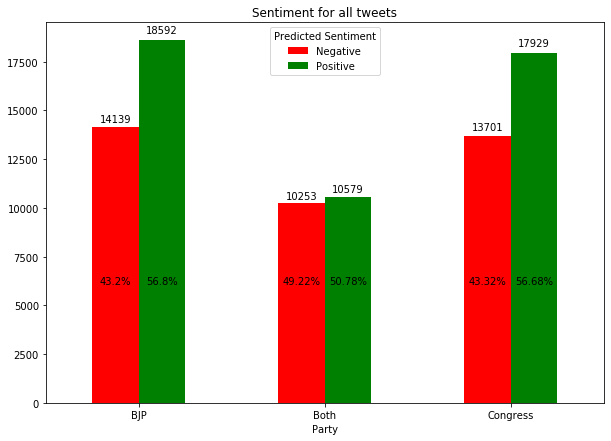

In [28]:
axAll = dfAll.iloc[:,:-1].plot(kind='bar',stacked = False, title = 'Sentiment for all tweets', mark_right = False,  figsize=(10,7), color = 'rg')

for p in axAll.patches:
    width1 = p.get_width()
    height1 = p.get_height()
    x1, y1 = p.get_xy() 
    axAll.annotate(f'{height1}', (x1 + width1/2, y1 + height1*1.02), ha='center')
    
for p in axAllPercentage.patches:
    width2 = p.get_width()
    height2 = p.get_height()
    x2, y2 = p.get_xy() 
    axAll.annotate(f'{height2}%', (x2 + width2/2, y2 + height1/3), ha='center', va='bottom')

plt.xticks(rotation=0)
plt.savefig('./Plots/SentimentAll.png')

## Analysis of Predicted Sentiment for tweets by Human accounts

In [29]:
# check distribution of predicted sentiment for each Human accounts only
dfHuman = tweets2019[tweets2019['Status']=='Human'].groupby(['Predicted Sentiment','Party']).size().reset_index(name='Count').pivot(index='Party',columns='Predicted Sentiment',values='Count')
dfHuman['Total'] = dfHuman.sum(axis=1)

dfHuman_total = dfHuman['Total']
dfHumanPercentage = round(dfHuman[dfHuman.columns[:-1]].div(dfHuman_total, 0)*100,2)

dfHuman

Predicted Sentiment,Negative,Positive,Total
Party,,,
BJP,12174,15627,27801
Both,8766,8700,17466
Congress,11627,14939,26566


In [ ]:
axHumanPercentage = dfHumanPercentage.plot(kind='bar',stacked = False, figsize=(10,7))

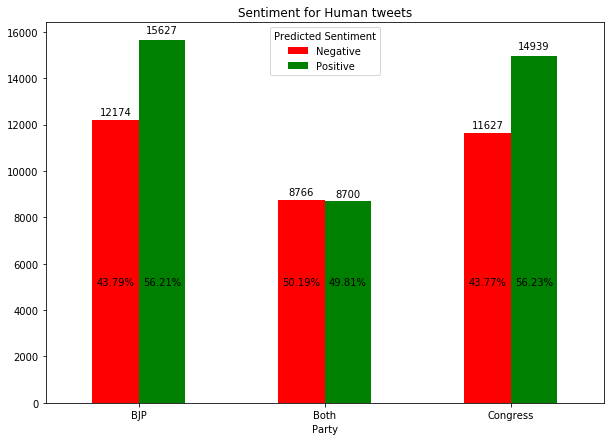

In [31]:
axHuman = dfHuman.iloc[:,:-1].plot(kind='bar',stacked = False, title = 'Sentiment for Human tweets', mark_right = False,  figsize=(10,7), color = 'rg')

for p in axHuman.patches:
    width1 = p.get_width()
    height1 = p.get_height()
    x1, y1 = p.get_xy() 
    axHuman.annotate(f'{height1}', (x1 + width1/2, y1 + height1*1.02), ha='center')
    
for p in axHumanPercentage.patches:
    width2 = p.get_width()
    height2 = p.get_height()
    x2, y2 = p.get_xy() 
    axHuman.annotate(f'{height2}%', (x2 + width1/2, y2 + height1/3), ha='center', va='bottom')
    
plt.xticks(rotation=0)
plt.savefig('./Plots/SentimentHuman.png')